# Bone Fracture Detection

#### Import the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array
import zipfile
import warnings
warnings.filterwarnings('ignore')

#### Download the dataset

In [2]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

Dataset URL: https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays
License(s): unknown
 98% 169M/172M [00:01<00:00, 115MB/s]
100% 172M/172M [00:01<00:00, 99.2MB/s]


#### Unzip the folder

In [3]:
zip_ref = zipfile.ZipFile('/content/bone-fracture-detection-using-xrays.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#### Preprocess the data

In [4]:
train_path = '/content/archive (6)/train'
test_path = '/content/archive (6)/val'

In [5]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


#### Model building using pre-trained EfficientNetB3

In [6]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

input_layer = layers.Input(shape=(224, 224, 3))
x = base_model(input_layer)
x = layers.GaussianNoise(0.25)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GaussianNoise(0.25)(x)
x = layers.Dropout(0.25)(x)

output_layer = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 7, 7, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,573,040 (44.15 MB)

 Trainable params: 788,481 (3.01 MB)

 Non-trainable params: 10,784,559 (41.14 MB)

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

#### Model Training

In [8]:
lrp=ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
call=[checkpoint,lrp]
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data=validation_generator,
    batch_size = 50,
    callbacks=call
    )

Epoch 1/10
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - AUC: 0.7752 - Precision: 0.7066 - Recall: 0.7121 - accuracy: 0.7091 - loss: 0.6136
Epoch 1: val_accuracy improved from -inf to 0.64500, saving model to best_model.keras
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 221s 82ms/step - AUC: 0.7752 - Precision: 0.7066 - Recall: 0.7121 - accuracy: 0.7091 - loss: 0.6136 - val_AUC: 0.7573 - val_Precision: 0.5410 - val_Recall: 0.7417 - val_accuracy: 0.6450 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 2/10
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.8621 - Precision: 0.7750 - Recall: 0.7788 - accuracy: 0.7766 - loss: 0.4632
Epoch 2: val_accuracy improved from 0.64500 to 0.65167, saving model to best_model.keras
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 150s 68ms/step - AUC: 0.8621 - Precision: 0.7750 - Recall: 0.7788 - accuracy: 0.7766 - loss: 0.4632 - val_AUC: 0.7086 - val_Precision: 0.5975 - val_Recall: 0.3958 - val_accuracy: 0.6517 - val_loss: 0.8107 - learning_rate: 0.0010
Epoch 3/10
2215/2216 ━━━━

#### Evaluation

In [9]:
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'The accuracy of the model is: {accuracy:.4f}')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step
The accuracy of the model is: 0.4733
               precision    recall  f1-score   support

    fractured       0.57      0.51      0.54       360
not fractured       0.36      0.42      0.39       240

     accuracy                           0.47       600
    macro avg       0.47      0.46      0.46       600
 weighted avg       0.49      0.47      0.48       600



#### Visualizing accuracy and loss over epochs

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

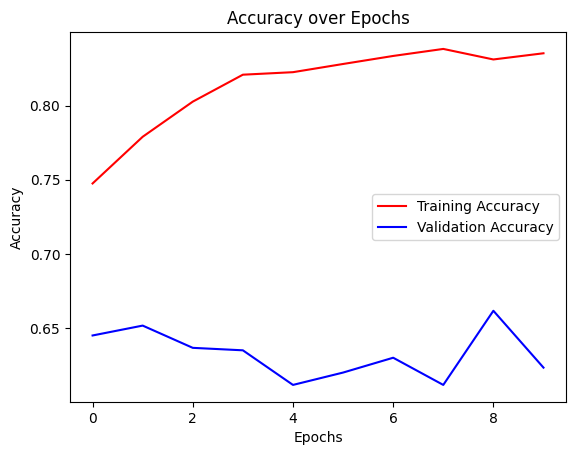

In [14]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

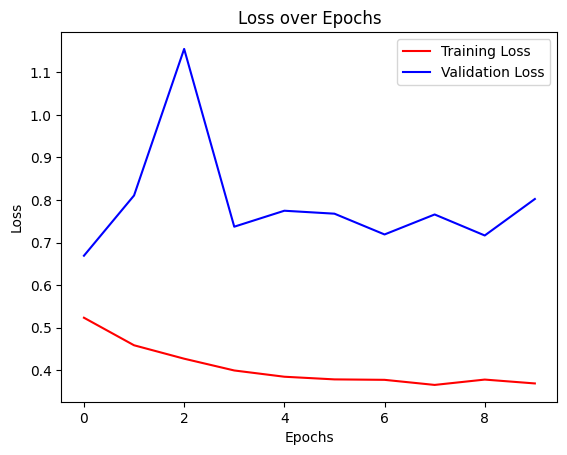

In [15]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model Prediction

In [10]:
def predict_bone_fracture(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    imag = img_to_array(img) 
    imaga = np.expand_dims(imag, axis=0)  
    
    ypred = model.predict(imaga)
    confidence = ypred[0][0]

    if confidence < 0.5:
        label = "Fracture"
        confidence_score = (1 - confidence) * 100
    else:
        label = "Normal"
        confidence_score = confidence * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='blue')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


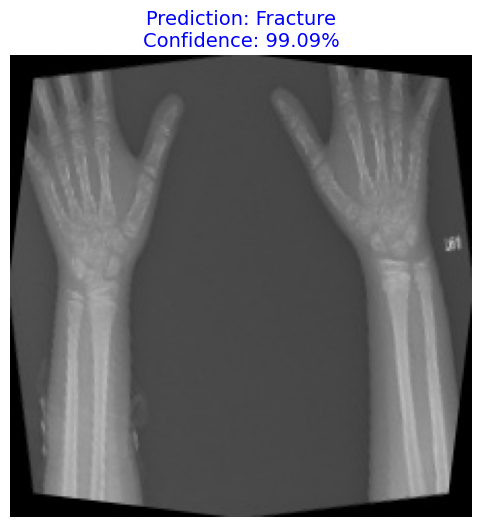

In [11]:
image_path = '/content/archive (6)/train/fractured/10-rotated1-rotated1.jpg'
predict_bone_fracture(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


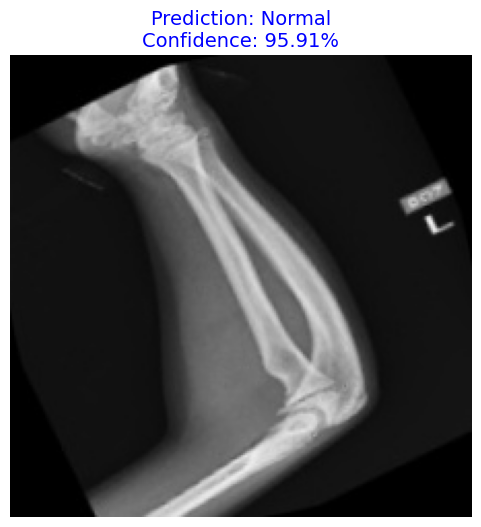

In [12]:
image_path = '/content/archive (6)/train/not fractured/10-rotated1-rotated1-rotated2.jpg'
predict_bone_fracture(image_path, model)